### Step by step design
1. Simulate Rankings of Relevance E and P
2. Calculate delta ERR
3. Implement Team-Draft (5pts) and Probabilistic Interleaving (35pts)
4. Simulate User Clicks (40pts)
5. Simulate Interleaving Experiment
6. Compute Sample Size
7. Analysis (20pts)

Homework description: https://docs.google.com/document/d/1sNat5t1asD6Jj7eCSWo_9esHoFYWrw9wjwE3kMdgMxc/edit#



In [1]:
import numpy as np
import itertools
import random as rnd
import math
from copy import deepcopy
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
CUT_OFF_RANK = 3
ranking_scale = range(2)

In [3]:
# Simulate all pairs of E and P
ranking_results = list(itertools.product(ranking_scale, repeat=CUT_OFF_RANK))
all_pairs = list(itertools.product(ranking_results, repeat=2))

In [4]:
############# CALCULATE ERR #############

def rel_grade_to_prob(grade):
    #map relevance grade to probability
    R_i = (2**grade)-1 / 2**(np.amax(ranking_scale))
    return R_i


def compute_err(ranked_results):
    #According to Algorithm 2 in ERR-paper
    err = 0    
    for r in range(1,CUT_OFF_RANK+1):        
        R_r = rel_grade_to_prob(ranked_results[r-1])
        for i in range(1,r):
            R_i = rel_grade_to_prob(ranked_results[i-1])
            R_r = R_r * (1-R_i)        
        err += R_r / r
        
    return err

In [5]:
# Create lookup table for ranked_results - ERR
dict_results_err = {}
for ranked_list in ranking_results:
    dict_results_err[ranked_list] = compute_err(ranked_list)
    


In [6]:
# Creating the bins for delta ERR
lower_bonds = np.round(np.linspace(0,1,num=10, endpoint=False), decimals=2)
lower_bonds[0] = 0.05
upper_bonds = np.round(np.linspace(0.1,1,num=10), decimals=2)
upper_bonds[-1] = 0.95
bins = list(zip(lower_bonds, upper_bonds))                                # [(0.05 - 0.1),(0.1 - 0.2),...,(0.9 - 0.95)]


In [7]:
############# CALCULATE DELTA ERR #############

#Compute delta ERR
dict_rel_pairs = {}
for upper in upper_bonds:
    dict_rel_pairs[upper] = []
all_delta_err = []
rel_delta_err = []

for pair in all_pairs:      
    delta_err = dict_results_err[pair[0]] - dict_results_err[pair[1]]    
    #add pair to corresponding group if E outperforms P
    if delta_err > lower_bonds[0]:        
        for bond in upper_bonds:            
            if delta_err < bond:                
                dict_rel_pairs[bond].append(pair)                
                rel_delta_err.append(delta_err)                
                break

Text(0.5,1,'Distribution of delta ERR over the bins')

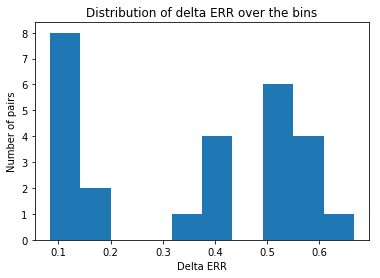

In [42]:
# Distribution of delta ERR over the bins
plt.hist(rel_delta_err, bins=10)
plt.ylabel("Number of pairs")
plt.xlabel("Delta ERR")
plt.title("Distribution of delta ERR over the bins")

In [9]:
# add document numbers which allow that the documents returned can be distict but also can overlap
# we considered there are 30 distinct documents in the collection D
# we need these numbers for correctly computing Team-Draft/Probabilistic Interleaving
def assign_doc_labels(pair):
    labeled_pair = []
    for ranked_list in pair:
        doc_labels = []
        docs_l = rnd.sample(range(1, 30), 3)        
        for i in docs_l:
            #generate doc labels
            doc_labels.append("d{0}".format(i))
            
        labeled_pair.append(list(zip(doc_labels,ranked_list)))
    return labeled_pair

In [10]:
# TEAM-DRAFT INTERLEAVING

# function which deletes a document from a list of documents
def remove_document_from_list(d, d_list):    
    for doc in d_list:        
        if d[0] == doc[0]:
            d_list.remove(doc)
            break

# function which computes the interleaved list based on Team-Draft approach
def team_draft_interleaving(pair, max_length=3):
    
    labeled_pair = assign_doc_labels(pair)                                 # add IDs to documents 
    teams = {"E": list(labeled_pair[0]), "P": list(labeled_pair[1])}       # separate the E and P ranked lists
    interleaved_list = []
    team_E = 0
    team_P = 0   
    
    while(len(interleaved_list) < max_length):        
        if team_E < team_P:                                                # choose document from E ranked list
            chosen_team = 'E'                  
            chosen_doc = teams['E'].pop(0)
            team_E += 1
            remove_document_from_list(chosen_doc,teams['P'])               # if the document is also in P list , then remove it
        elif team_E > team_P:                                              # choose document from P ranked list
            chosen_team = 'P'                    
            chosen_doc = teams['P'].pop(0)
            team_P += 1
            remove_document_from_list(chosen_doc,teams['E'])               # if the document is also in E list , then remove it
        elif team_E == team_P:                                             # choose randomly the ranked list from which we take 
            chosen_team = rnd.choice(list(teams.keys()))                   # the next document
            chosen_doc = teams[chosen_team].pop(0)
            if chosen_team == 'E':               
                team_E += 1
                remove_document_from_list(chosen_doc,teams['P'])           # if the document is also in P list , then remove it
            else:             
                team_P += 1
                remove_document_from_list(chosen_doc,teams['E'])           # if the document is also in E list , then remove it           
                
        interleaved_list.append((chosen_team,chosen_doc[1]))        

    return interleaved_list

In [11]:
# PROBABILISTIC INTERLEAVING

def inverse_power(x, power):
    return 1/(x**power)

def softmax_probabilities(num_ranks, tau=3):
    #Following formula (1) from Probabilistic Interleaving paper
    softmax_probs = []
    ranks = range(1, num_ranks+1)
    denominator = sum(list(inverse_power(r,tau) for r in ranks))    
    for rank in ranks:
        softmax_probs.append(inverse_power(rank,tau)/denominator)
    
    return softmax_probs

# Function which computes the interleaved list based on Probabilistic approach 
def probabilistic_interleaving(pair, max_length=3):
    interleaved_list = []
    labeled_pair = assign_doc_labels(pair)                                      # add IDs to documents 
    teams = {"E": list(labeled_pair[0]), "P": list(labeled_pair[1])}            # separate the E and P ranked lists
    
    while(len(interleaved_list) < max_length):
        chosen_team = rnd.choice(list(teams.keys()))                            # choose randomly the ranked list from which we take                            
        if chosen_team == 'E':                                                  # the next document
            other_team = 'P'
        else:
            other_team = 'E'            
        chosen_list = teams[chosen_team]        
        
        softmax_samples = softmax_probabilities(len(chosen_list))
        uni_sample = np.random.uniform(low=0.0, high=1.0)
        threshold = 0
        # select doc from list with respect to probabilities
        for prob in softmax_samples:
            threshold += prob            
            if uni_sample < threshold:                
                chosen_doc = chosen_list.pop(softmax_samples.index(prob))
                remove_document_from_list(chosen_doc,teams[other_team])        # remove the chosen document from the other list           
                interleaved_list.append((chosen_team,chosen_doc[1]))                  
                break               
    
    return interleaved_list

In [12]:
# POSITION-BASED CLICK MODEL 

cut_off = 3

# Reading the document and creating the dictionaries for storing the relevant data

f = open('YandexRelPredChallenge.txt','r')
d_query = {}          # dictionary with queryID as keys which stores all sessions that contain queryID and the clicked docIDs
d_doc_for_query = {}  # dictionary with queryID as keys which stores all unique docIDs given by that speciic query
i = 0
for line in f:   
    l = line.split()    
    
    if(l[2] == 'Q'):
        if(l[3] not in d_query.keys()):
            d_query[l[3]] = []
            d_doc_for_query[l[3]] = []
        
        d_doc_for_query[l[3]] = list(set().union(d_doc_for_query[l[3]],l[5:5+cut_off]))
        d_query[l[3]].append([])
        
        urls = l[5:5+cut_off]
        d_query[l[3]][len(d_query[l[3]]) - 1].append(urls)
        d_query[l[3]][len(d_query[l[3]]) - 1].append([])
        
        last_query = l[3]
    
    else:
        if l[3] in d_query[last_query][len(d_query[last_query]) - 1][0]:
            d_query[last_query][len(d_query[last_query]) - 1][1].append(l[3])            



In [13]:
# Computing the total number of sessions in the file
def session_number(d_query):
    sess_nr = 2
    for query in d_query.keys():
        sess_nr += len(d_query[query])
    return sess_nr

sess_nr = session_number(d_query)

In [14]:
# EM algorithm for Position-Based Model
# calculates the values of alphas and gammas
def position_based_model():                
    # initialize alphas
    alpha_q_u = {}
    for query in d_doc_for_query.keys():
        for doc in d_doc_for_query[query]:
            alpha_q_u[query+'_'+doc] = rnd.uniform(0,1)
    # initialize gammas
    gamma_r = {}
    for i in range(cut_off):
        gamma_r[str(i+1)] = rnd.uniform(0,1)


    T = 100

    for t in range(T):
        # gammas update at iteration t 
        old_gamma_r = deepcopy(gamma_r)
        
        suma = [1]*cut_off
        for q in d_query.keys():          # for each unique query in the log file
            for s,c in d_query[q]:        # for each session that includes this query
                for i in range(cut_off):  # for document at rank from 1 to 3
                    if s[i] in c:         # if the document was clicked in that session then add 1 to the update rule
                        suma[i] += 1
                    else:                 # else add the rest of the formula for gamma to the update rule
                        alpha_key = q + '_' + s[i]
                        suma[i] += (gamma_r[str(i+1)]*(1 - alpha_q_u[alpha_key]))/(1 - (gamma_r[str(i+1)]*alpha_q_u[alpha_key]))

        for i in range(cut_off):
            gamma_r[str(i+1)] = suma[i]/sess_nr  # normalize by the number of the sessions 

        # alphas update at iteration t
        for q in d_doc_for_query.keys():  # for each unique query in the log file
            for u in d_doc_for_query[q]:  # for each unique document retrieved by the query
                alpha_key = q + '_' + u   # compute the query_document unique key for the alpha dictionary

                suma1 = 1
                S_u_q = 2

                for s,c in d_query[q]:    # for each sessions that contains query q
                    if u in s:            # if document u is in this session then take it into account to the update rule
                        S_u_q += 1                    
                        if u in c:
                            suma1 += 1    # if document u was clicked in session s then add 1 to the update rule
                        else:             # else add the rest of the formula for alpha to the update rule
                            index = s.index(u) 
                            suma1 += ((1 - old_gamma_r[str(index+1)])*alpha_q_u[alpha_key])/(1 - (old_gamma_r[str(index+1)]*alpha_q_u[alpha_key]))

                alpha_q_u[alpha_key] = suma1/S_u_q  # normalize by the number of sessions taken into account
        
    return gamma_r

In [15]:
# Getting gamma values
gamma_r = position_based_model()
print(str(gamma_r['1']) + ' ' + str(gamma_r['2']) + ' ' + str(gamma_r['3']))

0.9994798490072738 0.4827779326568598 0.3336310767515496


In [16]:
#################    GETTING THE PROBABILITIES FROM PBM/RCM ###################

# Function wich computes the probabilities based on gammas from PBM and epsilon
def position_based_model_probs(ranked_list, epsilon = 0.1):
    probs = []
    r = 1
    for _, rel in ranked_list:
        if rel == 1:
            probs.append((1-epsilon)*gamma_r[str(r)])
        else: 
            probs.append(epsilon*gamma_r[str(r)])
        r += 1
    return probs
  
# Function which calculates the total number of clicks used to compute rho for Random Click Model
def click_number(d_query):    
    click_nr = 0
    for query in d_query.keys():
        for s,c in d_query[query]:
            click_nr += len(c)
    return click_nr

# Computing the probabilities for Random Click Model
def random_click_model_probs():
    rho = click_number(d_query)/(session_number(d_query)*CUT_OFF_RANK)
    return [rho]*CUT_OFF_RANK


In [ ]:
random_click_model_probs()

In [31]:
##################### SIMULATION OF USER CLICKS #########################

# Function which simulates the user clicks based on probabilities given by PBM/RCM
def sim_clicks(ranked_list, probs, epsilon = 0.1):
    clicks = []
    for r in range(CUT_OFF_RANK): 
        ran = rnd.uniform(0,1)
        if probs[r] < ran:
            clicks.append(1)
        else: 
            clicks.append(0)
    return clicks

# Function which calculates the winner system of a click simulation
def winner(interleaved_list, probs, epsilon = 0.1):
    clicks = sim_clicks(interleaved_list, probs, epsilon = 0.1)
    wins_E = 0
    wins_P = 0
    r = 0
    for alg, _ in interleaved_list:
        if clicks[r] == 1:
            if alg == 'E':
                wins_E += 1
            else:
                wins_P += 1
        r += 1
    if wins_E > wins_P:
        return 1
    elif wins_E < wins_P:
        return -1
    return 0


# interleaving: 0 - Team_Draft,           1 - Probabilistic
# click_model:  0 - Position-Based-Model, 1 - Random-Click-Model

# Function which calculates the percentage of wins of system E
def simulation(pair, interleaving, click_model, rho, K = 100, epsilon = 0.1):
    if interleaving  == 0:
        interleaved_list = team_draft_interleaving(pair, CUT_OFF_RANK)
    else:
        interleaved_list = probabilistic_interleaving(pair, CUT_OFF_RANK)

    if click_model == 0:
        probs = position_based_model_probs(interleaved_list,epsilon)
    else:
        probs = rho  

    wins_E = 0
    wins_P = 0
    
    for k in range(K):
        if winner(interleaved_list, probs, epsilon) == 1:
            wins_E += 1
        elif winner(interleaved_list, probs, epsilon) == -1:
            wins_P += 1
 
    if (wins_E + wins_P) != 0:
        return wins_E/(wins_E + wins_P)
    return 0


# Function which computes sample size from p value, alpha(0.05) and beta(0.10)
def sample_size(p1, p0=0.5, alpha=0.05, beta=0.10):
    z = norm.ppf(1-alpha)*math.sqrt(p0*(1-p0)) + norm.ppf(1-beta)*math.sqrt(p1*(1-p1))
    if (z == 0.0 or p1 == p0):
        return -1
    else:
        return ((z/(abs(p1-p0)))**2) + 1/abs(p1-p0)


In [40]:
#################   FILL THE TABLES  #################

# Function which computes min, median, max sample size values for a bin
def bin_min_median_max(err_bin, interleaving, click_model, K = 100, epsilon = 0.1, M = 1000):
    rho = random_click_model_probs()
    bin_sample_sizes = []
    for pair in dict_rel_pairs[err_bin]:
        for m in range(M):
            p = simulation(pair, interleaving, click_model, rho, K , epsilon)
            #print(p)
            n = sample_size(p)
            if n != -1:
                bin_sample_sizes.append(n)    
    
    average = np.round(np.mean(bin_sample_sizes))
    mini = min(bin_sample_sizes)
    std_values = []
    for val in bin_sample_sizes:
        if (val >= mini) and (val <= (average + average - mini)):
            std_values.append(val)
            
    std = np.std(std_values)    
    plt.hist(bin_sample_sizes, bins=range(0,100,3))
    plt.xlabel("Sample size")
    plt.ylabel("#occurrences")
    plt.title("Sample size for deltaERR = {0} with K={1} repititions for interleaving and over M={2} iterations".format(err_bin, K,M))
    
    return np.round(average - std), average, np.round(average + std)

# Function witch computes the values for all bins
def fill_table(all_bins, interleaving , click_model, K = 100, epsilon = 0.1, M = 1000):
    table = {}
    for bin_key in all_bins.keys():
        if len(all_bins[bin_key]) > 0:
            table[bin_key] = list(bin_min_median_max(bin_key,interleaving,click_model,K, epsilon ,M))
            
    return table

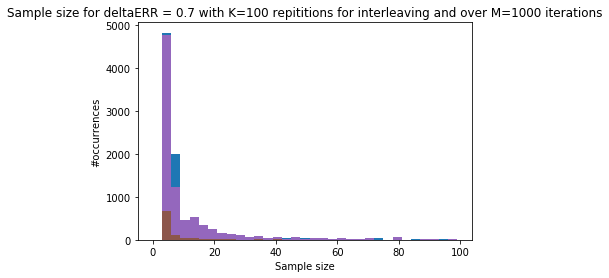

In [41]:
# Team-draft Interleaving with Position-Based Click Model
table_0_0 = fill_table(dict_rel_pairs, 0 , 0, K = 100, epsilon = 0.1, M = 1000)

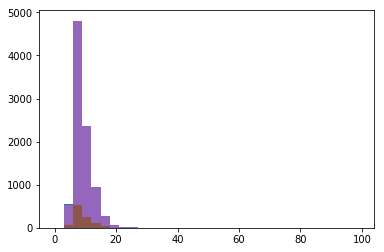

In [20]:
# Team-draft Interleaving with Random Click Model
table_0_1 = fill_table(dict_rel_pairs, 0 , 1, K = 100, epsilon = 0.1, M = 1000)

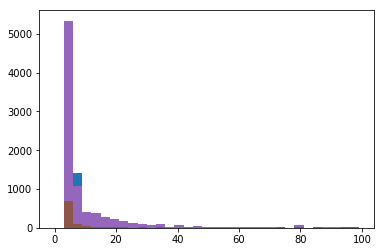

In [21]:
# Probabilistic Interleaving with Position-Based Click Model
table_1_0 = fill_table(dict_rel_pairs, 1 , 0, K = 100, epsilon = 0.1, M = 1000)

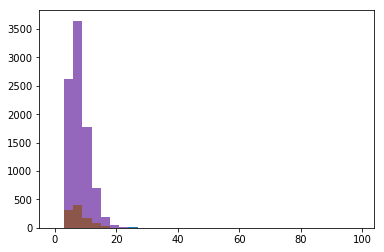

In [22]:
# Probabilistic Interleaving with Random Click Model
table_1_1 = fill_table(dict_rel_pairs, 1 , 1, K = 100, epsilon = 0.1, M = 1000)

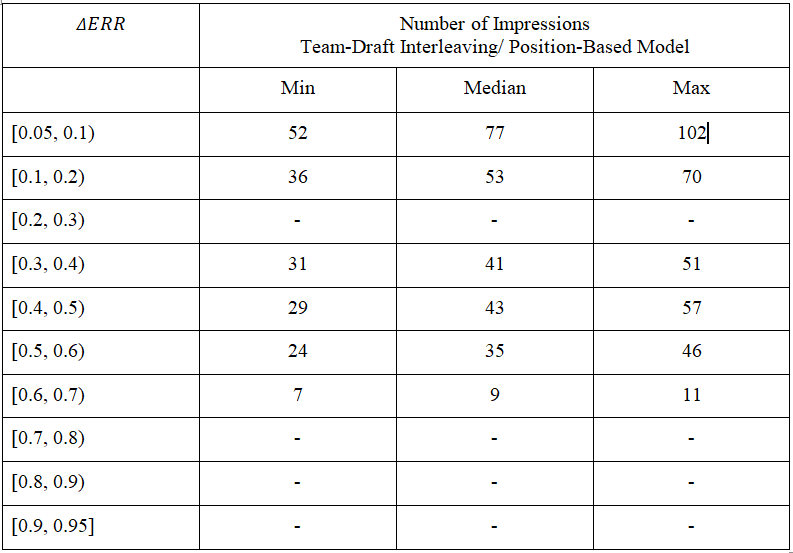


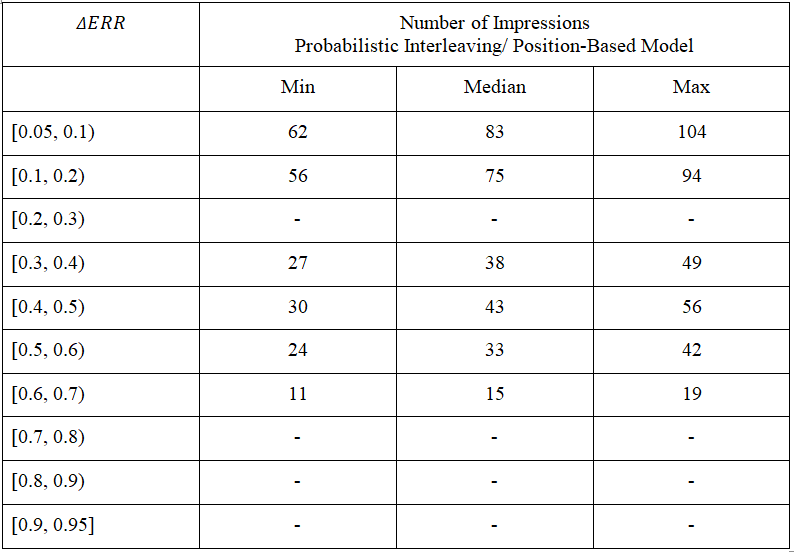

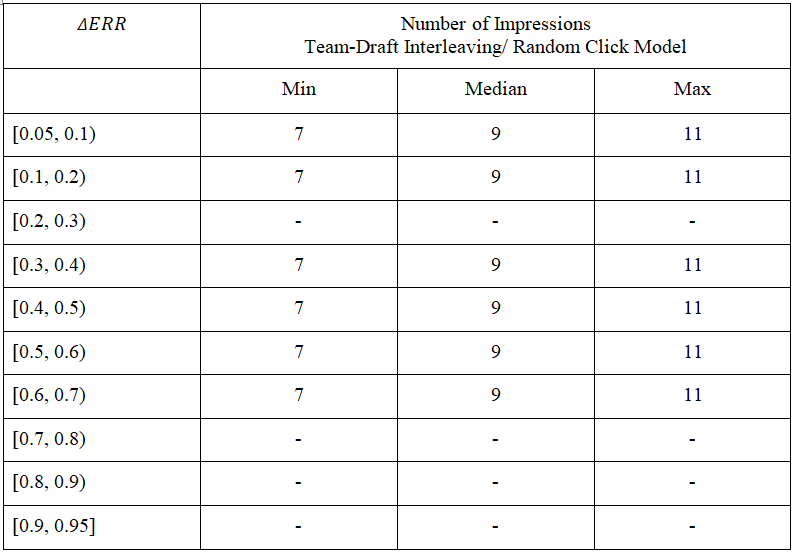

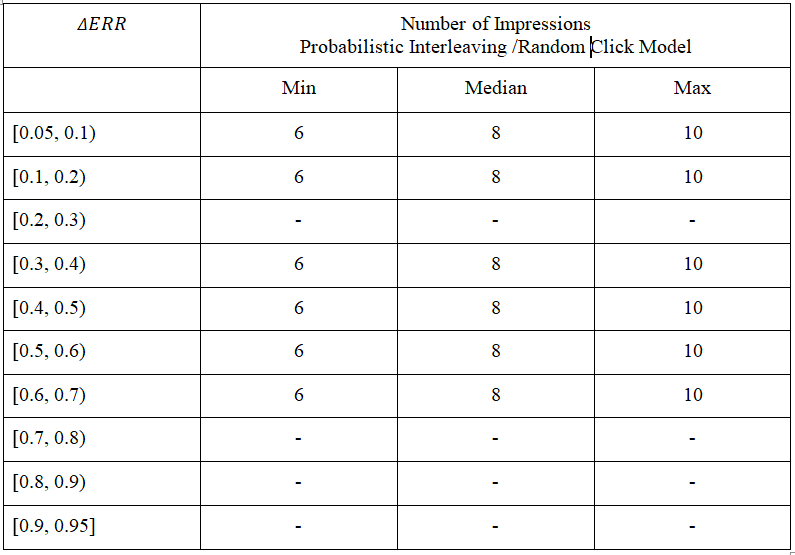

## Analysis

From the experiment and the tables above, several observations and insight can be inferred: 

1. Not all rows are filled: Although all possible permutations pairs with <b>cut-off rank 3</b> and a <b>binary relevance scheme</b> are generated, there're no data points for some groups (see image below). This is due to the limitations in length and relevance scheme on which the ERR is computed. The completed tables (see above) also confirm the expected trend that for growing effect size (dERR) fewer impressions are required for statistical significance. This insight aligns with the basic intuition that only few samples are needed to show that a relatively big performance difference does occur by design, and not by chance. Therefore, for smaller effect sizes, more impressions are needed to show that the predicted performance difference actually results from the algorithm and rather than from randomness.

Text(0.5,1,'Distribution of delta ERR over the bins')

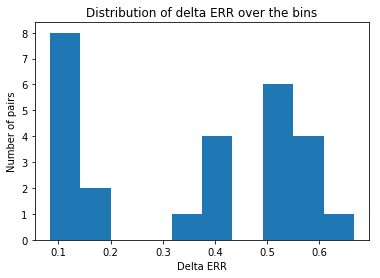

In [43]:
# Distribution of delta ERR over the bins
plt.hist(rel_delta_err, bins=10)
plt.ylabel("Number of pairs")
plt.xlabel("Delta ERR")
plt.title("Distribution of delta ERR over the bins")



2. Difference between team-draft and probabilistic: The two interleaving methods show very similar estimates for the sample sizes over all groups. However, when using team-draft interleaving the maximum sample sizes are usually slightly smaller compared to the probabilistic interleaving, especially for the first and last group. Although the team-draft method is more likely to exlude relevant results due to its <b>top-down approach</b>, it generally indicates better effectiveness through smaller sample sizes. The aim of the probabilistic interleaving was to create the possibility that documents (relevant or not) from other ranks also have a <b>non-zero probability</b> (assigned by the softmax function) of being selected for the interleaved list. This should help to include different documents independent of the rank in order to reflect the differences between the ranking systems (rankers) E and P. In order to perform the interleaving correctly, each document needs a unique ID in order to assemble interleaved list with distinct documents. In this experiment, a total of collection of <b>D = 30</b> documents are assumed, which are randomly assigned to the documents from each ranking system. During the interleaving process those ID's are checked to avoid overlapping. The values presented in the tables above are adapted to , trying to exclude the outliers and provide more representative numbers. The minimum and maximum value are therefore computed by adding or substracting one standard deviation from the average value respestively. This adaptation method helps to build meaningful threshold instead of taking absolute values, which are not very representative because of their extreme deviation from the mean and can therefore be considered outliers.

3. Difference between postion-based (PBM) and random click model (RCM): The two click models show a great difference for the number of impresions. The RCM does not take into account the relevance nor rank of document. When assigning the probabilities of clicking a document it is assumed that <b>all documents are equally important</b> and each has the same probability. But not be trusted because it determines the winner only on randomness and not their actual performance. For instance, if one of the rankers gives very good (relevant) results, it is not necessarily rewarded for that with user clicks. So, theorethically the maximum number of impressions for the RCM should go to infinity because in some cases there will not be significant difference.

4. Choosing value for epsilon: The value for epsilon should reflect reasonable assumptions about the clicking behaviour. Additionally, its influence on the total probability that a document is clicked must be taken into account: very small values for epsilon would basically eliminate the importance of the gamma and would consequently set the probability that a non-relevant document is clicked <b>virtually to zero</b>. In this experiment, the value of epsilon for the PBM is set to $epsilon = 0.1$ to reflect that the user clicks on document that he likes with a high probability but that in some cases (1/10) he decides not to click on it or makes a (random) misclick. 


## Outlook

The tables could help to estimate required resources (time, computational) better but for a real-world experiment one should not assume the minimum but rather median or maximum number of impressions for realistic estimates. In further experiments different values for Type I and II error (alpha & beta) or epsilon can be tested.  

We could use other click models and user logs for more personalized and thus more relevant results. Build sense for topic: From the logs we could also attempt to find out relations between queries and other knowledge about natural languages (e.g. semantic relations). A session is until the user is satisfied with the results, not just one query. 

The chosen cut-off rank at three poses some unfairness for the interleaving methods. When counting the total wins of one ranking system over the other, it would be fairer to have equal number of documents (or at least a chance) in the interleaved  list. This could be solved with an even value for the cut-off rank. 

Also we could use different measurements of interest instead of ERR (e.g. DCG, RBP). Other measurements would most likely yield different results for the number of impressions. The formula could be implemented and the computations are done in the same way, assuming the appropriate click model.

As an alternative to interleaving we could also try A/B-testing where for one input query both systems E and P produce a ranked list. These lists are then evaluated by group A and B respectively. The major challenge with A/B-testing would be the evaluation of user satisfaction. We cannot only rely on clicks but should also include more behaviour metrics (e.g. dwell time, mouse movement). In the simulation we could then see which algorithm satifies the user more and thus "wins" over the other. 


Literature used for this experiment and the improvement ideas: 

http://olivier.chapelle.cc/pub/err.pdf

http://www.cs.ox.ac.uk/people/shimon.whiteson/pubs/hofmanncikm11.pdf

https://staff.fnwi.uva.nl/h.azarbonyad/wp-content/uploads/power-analysis-for-online-evaluation.pdf